In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import expm
from datetime import datetime
import time
import scipy.sparse as sp

In [25]:
time_start = time.time()

##FDM quantities
##Discretise space:
N = 256
x = np.linspace(-1,1,N)
dx = x[1] - x[0]
##set initial conditions
u = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
u[0] = -1
u[-1] = 1
## Differentiation matrix plus identity:
D = sp.diags([1,-2,1],[-1,0,1],shape=(N,N)).toarray()/(dx**2)
I = np.eye(N)
##Linear operator L:
L = 0.01*D
L[0,:] = L[-1,:] = 0
L[0,0] = L[-1,-1] = 1


##ETD quantities

h = 1/4
M = 64

r = 15 * np.exp(1j * 2*np.pi * (np.arange(1, M+1) - 0.5) / M)

A = h * L
A[0,0] = np.log(1)
A[-1,-1] = np.log(1)
E = expm(A)
E2 = expm(A / 2)

I = np.eye(N)
Z = np.zeros((N, N))

f1 = Z.copy()
f2 = Z.copy()
f3 = Z.copy()
Q  = Z.copy()

for j in range(M):
    z = r[j]
    zIA = np.linalg.inv(z * I - A)

    Q  = Q + h * zIA * (np.exp(z/2) - 1)
    f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
    f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
    f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

Q  = np.real(Q)/M
f1 = np.real(f1)/M
f2 = np.real(f2)/M
f3 = np.real(f3)/M

uu = u.reshape(-1, 1)
tt = np.array([0.0])

tmax = 70
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 20) / h))

for n in range(1, nmax + 1):
    #print("n = ", n)
    t = n * h

    Nu = u-u**3
    a  = E2 @ u + Q @ Nu
    Na = a-a**3

    b  = E2 @ u + Q @ Na
    Nb = b-b**3

    c  = E2 @ a + Q @ (2*Nb - Nu)
    Nc = c-c**3

    u = E @ u + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

    if n % nplt == 0:
        #print("Saving at t = ", t)
        u[0] = -1
        u[-1] = 1
        uu = np.hstack((uu, u.reshape(-1, 1)))
        tt = np.append(tt, t)
        
time_end = time.time()
time_elapsed = time_end - time_start
print(f"ETD_AC execution time: {time_elapsed} seconds")

ETD_AC execution time: 1.0774509906768799 seconds


In [26]:
E[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
L

array([[   1.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [ 162.5625, -325.125 ,  162.5625, ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,  162.5625, -325.125 , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ..., -325.125 ,  162.5625,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,  162.5625, -325.125 ,
         162.5625],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           1.    ]])

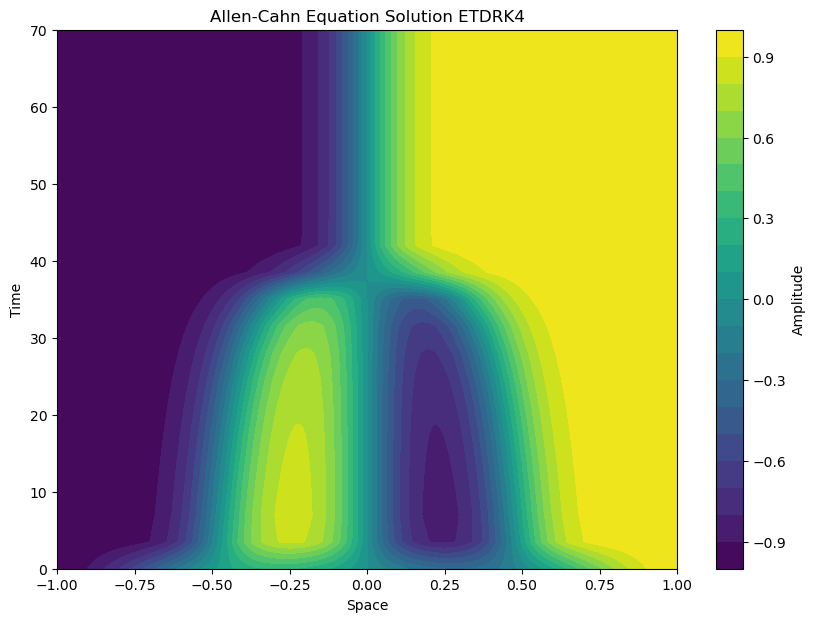

In [29]:
# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(X,T, uu[:,:], cmap=cm.viridis, levels=np.linspace(-1,1,21))  # Swap X and T to match uu's shape

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_title('Allen-Cahn Equation Solution ETDRK4')

plt.show()
